# Module 2 Coding Assignment: Retail Sales Data Analysis with LLM


In this assignment, you will use LangChain and LLMs to perform advanced data analysis tasks that previously required extensive coding. By interacting with a CSV dataset through LangChain's pandas dataframe agent, you will explore data, create visualizations, and even apply machine learning techniques—tasks traditionally done by skilled developers—using natural language.

# Why and How is it differnt from M1 assignment
In the previous assignment, we demonstrated how you can interact with LLMs in a browser to perform advanced data analysis. However, this approach can be challenging to integrate into your everyday workflow. In this assignment, we’ll show you how to leverage a Langchain agent to handle the heavy lifting—running the code generated by the LLM, debugging it until you achieve the desired results, and seamlessly integrating the output into your existing data analysis/visualization pipeline.

# Senario: Columbia Plus Mart Transaction Data Analysis
You are a Sales Analyst at Columbia Plus Mart, a retail store with a wide range of products across different categories. Your task is to analyze sales data to uncover valuable insights that will help improve the company's performance. You're provided with a dataset that includes customer purchases, product categories, order amounts, and more.

# Tasks
## 1. Data Exploration

Use the Langchain agent with pandas to explore and clean the dataset. Identify any missing values, outliers, or trends.

## 2. Sales Analysis

Explore when order hikes or drops occur (e.g., specific months, days of the week, or during sales events).

## 3. Customer Insights with Machine Learning

Identify different customer groups and which product categories they tend to favor the most. This might involve clustering based on spending patterns, demographics, or product categories.

## 4. Hypothesis Testing
Based on everything we learn about our customers in Task 1, 2, and 3, we might have some hypothesis about our customers and we will be testing a few hypothesis to see if they are statistically sound.

# More on the dataset
You can download the dataset here: https://www.kaggle.com/datasets/manjeetsingh/retaildataset

The dataset contains the following columns:

* Transaction ID: Unique identifier for each transaction.

* Date: The date of the transaction.

* Customer ID: Unique identifier for each customer.

* Gender: The gender of the customer.

* Age: The age of the customer.

* Product Category: The category of the product purchased (e.g., Beauty, Clothing, Electronics).

* Quantity: The number of units purchased.

* Price per Unit: The price of a single unit of the product.

* Total Amount: The total cost of the transaction (Quantity * Price per Unit).




# Preparation: Install Required Libraries
In this first step, we will install the necessary libraries to interact with the dataset and use the LangChain tool for querying the data.


In [ ]:
# freezing the coding environment to these specific versions
!pip install openai==1.72.0 langchain==0.3.23 langchain_openai==0.3.13 langchain_experimental==0.3.4 langchain_community==0.3.21 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.3/433.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.1 MB/s eta 0:00:00


# Preparation: Load API Key and Dataset
Now, let's mount Google Drive and load the API key along with the retail sales dataset from the uploaded file into a pandas DataFrame.

***If you don't have an OpenAI API key yet, please visit https://platform.openai.com/api-keys to acquire an API key as you will need it for this and following assignments.***

Make sure you change the `pth` object to reflect where you upload your assignment notebooks, API key, and dataset file.

In [ ]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_experimental.agents import create_pandas_dataframe_agent
import openai
import os

# Mount the google drive
from google.colab import drive
import os
drive.mount('/content/drive')

# You will need to update this path to where you upload your assignment notebooks, API key, and dataset file
pth = '/content/drive/MyDrive/GenAI for Technical Professionals (Hardeep Johar)/Jupyter Notebook/Assignment'
os.chdir(pth)

# Read the key from the file and set the environmental variable
with open("api/openai","r") as f:
  key=f.read().strip()
os.environ["OPENAI_API_KEY"] = key

# Path to the dataset file, you might need to change it depending on where you uploaded the dataset
file_path = 'data/retail_sales_dataset.csv'
df = pd.read_csv(file_path)
# Show the first few rows of the dataset
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
5,6,2023-04-25,CUST006,Female,45,Beauty,1,30,30
6,7,2023-03-13,CUST007,Male,46,Clothing,2,25,50
7,8,2023-02-22,CUST008,Male,30,Electronics,4,25,100
8,9,2023-12-13,CUST009,Male,63,Electronics,2,300,600
9,10,2023-10-07,CUST010,Female,52,Clothing,4,50,200


# Preparation: Create LangChain Agent

We will now create a LangChain agent that allows us to interact with the dataset through natural language queries. This agent will analyze the data and respond with insights.



In [ ]:
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2
)

# set up the pandas dataframe agent
agent_executor = create_pandas_dataframe_agent(llm,
                                      df,
                                      number_of_head_rows=1000, # Set this to the total number of rows in df
                                      agent_type="openai-tools",
                                      allow_dangerous_code = True,
                                      verbose=True)

# Now we got all the setup taken care of, let's get start with our tasks!

# Prompt Engineering Tip
After some experimentation, I found that it works best when you attach

***The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows. Thank you!***

at the end of your prompt. Keep this in mind when you perform the below tasks.


# Step 1: Data Exploration

Use the Langchain agent with pandas to explore and clean the dataset. Identify any missing values, outliers, or trends.

## Sample prompt
***Can you help me explore and clean the dataset. Identify any missing values, outliers, or trends? The data you need is in data/retail_sales_dataset.csv. The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows. Thank you!***


In [ ]:
# Change this prompt and observe how the response changes
prompt = """
Can you help me explore and clean the dataset.
Identify any missing values, outliers, or trends.
The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows. Thank you!
"""
response = agent_executor.invoke(prompt)



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\ndf = pd.read_csv('data/retail_sales_dataset.csv')\ndf.info()"}`


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB

Invoking: `python_repl_ast` with `{'query': 'df.describe()'}`


       Transaction ID         Age     Quantity  Price per Unit  Total Amount
count     1000.000000  

## Let's take a look at the return object
The chain consists of both the input we provided to the LangChain agent and the agent’s output after executing the code on our behalf. The agent runs the code, processes the results, and returns the relevant insights, such as the summary statistics, missing values, and trends found in the dataset.

In [ ]:
response

{'input': 'Can you help me explore and clean the dataset. Identify any missing values, outliers, or trends? The data you need is in data/retail_sales_dataset.csv. Use all 1000 rows of it and report characteristics of each group and how many customers are in each group. Use visualization for clarity. Thank you!',
 'output': "Here's a detailed exploration and cleaning of the dataset:\n\n### Missing Values\n- There are no missing values in the dataset. Each column has complete data.\n\n### Outliers\n- A boxplot was used to detect outliers in the columns 'Age', 'Quantity', 'Price per Unit', and 'Total Amount'. The visualization helps identify any potential outliers visually.\n\n### Data Structure and Statistical Insights\n- The dataset contains 1000 entries with the following columns: Transaction ID, Date, Customer ID, Gender, Age, Product Category, Quantity, Price per Unit, and Total Amount.\n- The statistical description of the dataset is as follows:\n  - **Age**: Ranges from 18 to 64, w

## Print it out for better readability

In [ ]:
print(response['output'])
# This is markup format, and you can copy this to a text cell for better readability

Here's a detailed exploration and cleaning of the dataset:

### Missing Values
- There are no missing values in the dataset. Each column has complete data.

### Outliers
- A boxplot was used to detect outliers in the columns 'Age', 'Quantity', 'Price per Unit', and 'Total Amount'. The visualization helps identify any potential outliers visually.

### Data Structure and Statistical Insights
- The dataset contains 1000 entries with the following columns: Transaction ID, Date, Customer ID, Gender, Age, Product Category, Quantity, Price per Unit, and Total Amount.
- The statistical description of the dataset is as follows:
  - **Age**: Ranges from 18 to 64, with a mean age of approximately 41.39.
  - **Quantity**: Ranges from 1 to 4, with a mean quantity of approximately 2.51.
  - **Price per Unit**: Ranges from 25 to 500, with a mean price of approximately 179.89.
  - **Total Amount**: Ranges from 25 to 2000, with a mean total amount of 456.

### Group Characteristics
- The dataset was gr

# Step 2: Sales Analysis

Explore when order hikes or drops occur (e.g., specific months, days of the week, or during sales events).

## Sample prompt
***Could you assist me in conducting a deeper sales analysis on the dataset? I'm particularly interested in identifying trends such as periods of order increases or decreases, along with other relevant insights. Please use visualizations to present the findings clearly. The data you need is in data/retail_sales_dataset.csv. Use all 1000 rows of it. Thank you!***



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\ndf = pd.read_csv('data/retail_sales_dataset.csv')\ndf['Date'] = pd.to_datetime(df['Date'])\ndf.set_index('Date', inplace=True)\n\n# Resample the data by month and sum the total amount\nmonthly_sales = df['Total Amount'].resample('M').sum()\n\n# Plot the monthly sales trend\nplt.figure(figsize=(12, 6))\nplt.plot(monthly_sales.index, monthly_sales.values, marker='o')\nplt.title('Monthly Sales Trend')\nplt.xlabel('Month')\nplt.ylabel('Total Sales Amount')\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"}`




<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


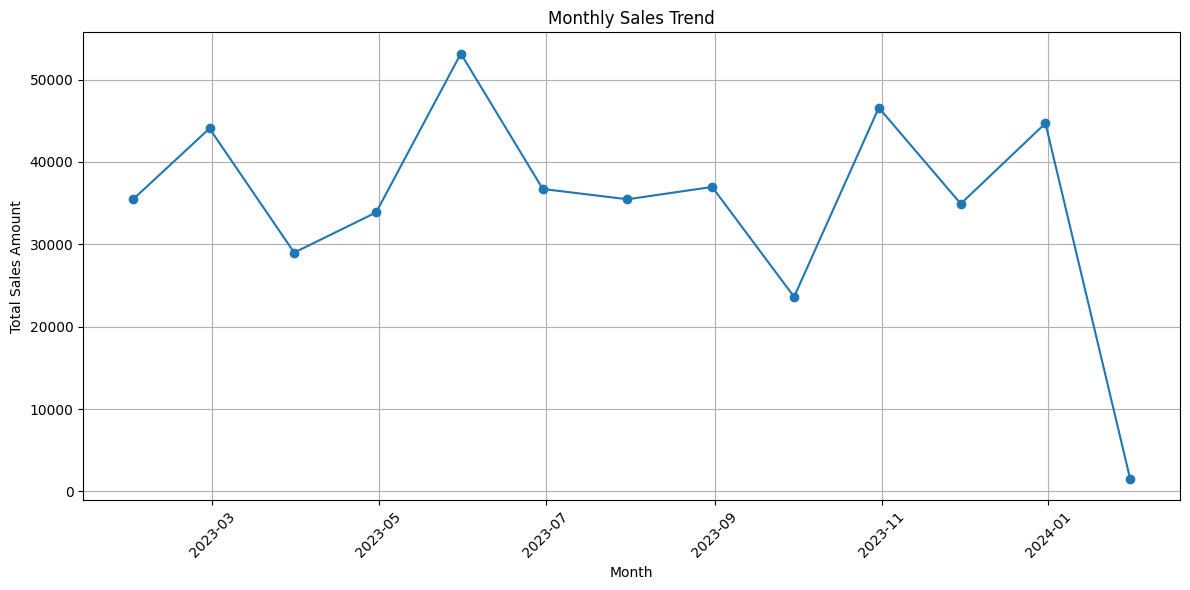

The visualization of the monthly sales trend has been generated. It displays the total sales amount for each month, allowing us to observe periods of increase or decrease in sales. 

To further analyze the data, we can look into specific trends such as seasonal patterns, the impact of specific events, or changes in consumer behavior over time. If you have any specific aspects you would like to explore further, please let me know!

> Finished chain.


In [ ]:
# Change this prompt and observe how the response changes
prompt = """
Could you assist me in conducting a deeper sales analysis on the dataset?
I'm particularly interested in identifying trends such as periods of order increases or decreases, along with other relevant insights.
Please use visualizations to present the findings clearly.
The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows. Thank you!
"""
response = agent_executor.invoke(prompt)

## Review the agent's response and what's your comment?

In [ ]:
print(response['output'])

The visualization of the monthly sales trend has been generated. It displays the total sales amount for each month, allowing us to observe periods of increase or decrease in sales. 

To further analyze the data, we can look into specific trends such as seasonal patterns, the impact of specific events, or changes in consumer behavior over time. If you have any specific aspects you would like to explore further, please let me know!


# Step 3: Customer Insights with Machine Learning
Identify different customer groups and which product categories they tend to favor the most. This might involve clustering based on spending patterns, demographics, or product categories.

## Sample Prompt
***Could you help me identify distinct customer groups based on their spending patterns, demographics, and product preferences? I'd also like recommendations on sales strategies for each group. Please provide insights on the characteristics of each group, including the number of customers in each, and use visualizations to present the results clearly. The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows. Thank you!***



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\ndf = pd.read_csv('data/retail_sales_dataset.csv')\ndf.head()"}`


   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100  

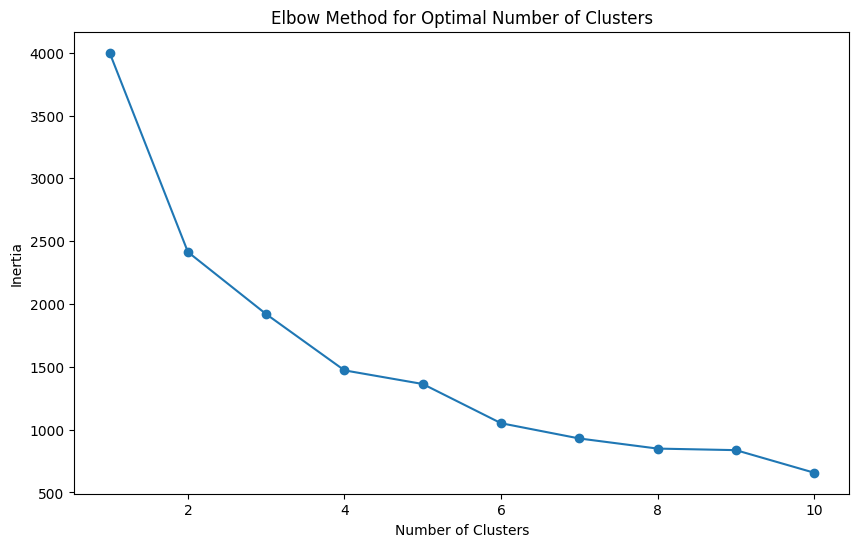


Invoking: `python_repl_ast` with `{'query': "# Let's perform clustering to identify distinct customer groups based on spending patterns, demographics, and product preferences.\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.cluster import KMeans\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Selecting relevant features for clustering\nfeatures = df[['Age', 'Quantity', 'Price per Unit', 'Total Amount']]\n\n# Standardizing the features\nscaler = StandardScaler()\nscaled_features = scaler.fit_transform(features)\n\n# Using the elbow method to find the optimal number of clusters\ninertia = []\nfor n in range(1, 11):\n    kmeans = KMeans(n_clusters=n, random_state=42)\n    kmeans.fit(scaled_features)\n    inertia.append(kmeans.inertia_)\n\n# Plotting the elbow curve\nplt.figure(figsize=(10, 6))\nplt.plot(range(1, 11), inertia, marker='o')\nplt.title('Elbow Method for Optimal Number of Clusters')\nplt.xlabel('Number of Clusters')\nplt.ylabel('Inertia')\nplt.sho

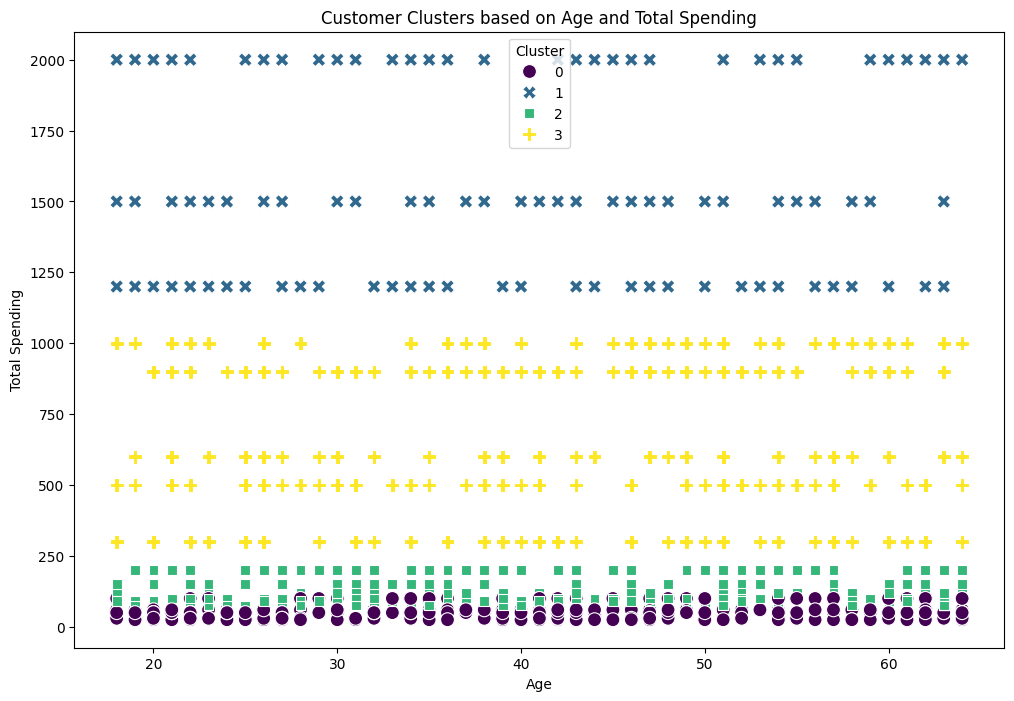

The scatter plot visualizes the customer clusters based on age and total spending. Each cluster is represented by a different color and style, allowing us to see the distribution and spending patterns of each group. This visualization can help tailor marketing strategies to target specific customer segments effectively.

> Finished chain.


In [ ]:
# Change this prompt and observe how the response changes
prompt = """
Could you help me identify distinct customer groups based on their spending patterns, demographics, and product preferences?
I'd also like recommendations on sales strategies for each group.
Please provide insights on the characteristics of each group, including the number of customers in each.
Use visualizations to present the results clearly.
The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows. Thank you!
"""
response = agent_executor.invoke(prompt)

## Let's review the agent's response closely

* Does the clustering make sense to you?
* How about the sales strategies for each cluster.

In [ ]:
print(response['output'])

The customer segmentation resulted in four distinct clusters. Here are the characteristics of each group:

1. **Cluster 0:**
   - **Number of Customers:** 256
   - **Average Total Amount Spent:** $204.28
   - **Average Age:** 27.74 years
   - **Average Quantity Purchased:** 1.70
   - **Characteristics:** Younger customers with moderate spending and lower quantity purchases.
   - **Sales Strategy:** Focus on promotions and discounts to encourage higher spending. Consider loyalty programs to increase purchase frequency.

2. **Cluster 1:**
   - **Number of Customers:** 220
   - **Average Total Amount Spent:** $1359.09
   - **Average Age:** 39.12 years
   - **Average Quantity Purchased:** 3.43
   - **Characteristics:** Middle-aged customers with high spending and moderate quantity purchases.
   - **Sales Strategy:** Offer premium products and exclusive deals. Personalized marketing and VIP customer service can enhance loyalty.

3. **Cluster 2:**
   - **Number of Customers:** 286
   - **Ave

# Step 4: Hypothesis Testing
Based on everything we learn about our customers in Task 1, 2, and 3, we might have some hypothesis about our customers and we will be testing a few hypothesis to see if they are statistically sound.



## Hypothesis 1: Customer age has no effect on quantity of purchase.

## Sample prompt:
***Please help me test the following hypothesis:
Null Hypothesis: Age has no effect on quantity of purchase.
Alternate hypothesis: Age has an effect on quantity of purchase.
The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows.***

In [ ]:
# Change this prompt and observe how the response changes
prompt = """
Please help me test the following hypothesis:
Null Hypothesis: Age has no effect on quantity of purchase.
Alternate hypothesis: Age has an effect on quantity of purchase.
The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows.
"""
response = agent_executor.invoke(prompt)



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nfrom scipy.stats import f_oneway\n\ndf = pd.read_csv('data/retail_sales_dataset.csv')\n# Check the unique ages in the dataset\ndf['Age'].unique()"}`


[34 26 50 37 30 45 46 63 52 23 35 22 64 42 19 27 47 62 18 49 28 38 43 39
 44 51 58 48 55 20 40 54 36 31 21 57 25 56 29 61 32 41 59 60 33 53 24]
Invoking: `python_repl_ast` with `{'query': '# Check the first few rows to understand the structure of the dataset\ndf.head()'}`


   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Pri

In [ ]:
print(response['output'])

The ANOVA test results are as follows:

- F-statistic: 0.909
- p-value: 0.647

Given that the p-value (0.647) is greater than the common significance level of 0.05, we fail to reject the null hypothesis. This suggests that there is no statistically significant effect of age on the quantity of purchase in this dataset.


## Hypothesis 2: Sales time (such as month and weekdays) has no effect on the total amount of purchase.

## Sample prompt:
***Please help me test the following hypothesis:
Null Hypothesis: Sales time (such as month and weekdays) has no effect on the total amount of purchase.
Alternative Hypothesis: Sales time (such as month and weekdays) does have an effect on the total amount of purchase.
The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows.***

In [ ]:
# Change this prompt and observe how the response changes
prompt = """
Please help me test the following hypothesis:
Null Hypothesis: Sales time (such as month and weekdays) has no effect on the total amount of purchase.
Alternative Hypothesis: Sales time (such as month and weekdays) does have an effect on the total amount of purchase.
The dataset is available at data/retail_sales_dataset.csv, and I’d like you to use all 1000 rows.
"""
response = agent_executor.invoke(prompt)




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\n\ndf = pd.read_csv('data/retail_sales_dataset.csv')\ndf['Date'] = pd.to_datetime(df['Date'])\ndf['Month'] = df['Date'].dt.month\ndf['Weekday'] = df['Date'].dt.weekday\ndf.head()"}`


   Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     CUST001    Male   34           Beauty   
1               2 2023-02-27     CUST002  Female   26         Clothing   
2               3 2023-01-13     CUST003    Male   50      Electronics   
3               4 2023-05-21     CUST004    Male   37         Clothing   
4               5 2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  Month  Weekday  
0         3              50           150     11        4  
1         2             500          1000      2        0  
2         1              30            30      1        4  
3         1             5

In [ ]:
print(response['output'])

The ANOVA test results for the effect of sales time on the total amount of purchase are as follows:

1. **Effect of Month on Total Amount:**
   - F-statistic: 0.7118
   - p-value: 0.7280

2. **Effect of Weekday on Total Amount:**
   - F-statistic: 0.6641
   - p-value: 0.6787

### Interpretation:
- The p-values for both the month and weekday are greater than the common significance level of 0.05. 
- This indicates that we fail to reject the null hypothesis for both tests.

### Conclusion:
- There is no statistically significant effect of the sales time (month or weekday) on the total amount of purchase based on the given dataset.


## What other hypothesis do you have? Test it out here!

# Summary

In this notebook, we leveraged the power of LangChain and LLMs to perform advanced retail data analysis tasks. By interacting with retail sales dataset through a LangChain pandas DataFrame agent, we were able to:

* **Explore and Clean the Data:** We identified missing values, outliers, and initial trends in the dataset, ensuring data quality for further analysis.
* **Analyze Sales Trends:** We uncovered insights into sales patterns, including periods of order increases and decreases, providing valuable information for strategic decision-making.
* **Gain Customer Insights:** We identified distinct customer groups based on spending habits, demographics, and product preferences. These insights helped in understanding customer behavior and tailoring sales strategies.
* **Test Hypotheses:** We tested statistically sound hypotheses about customer behavior, such as the relationship between age and purchase quantity and the impact of sales time on purchase amount.

This approach demonstrates the potential of LLMs in simplifying complex data analysis tasks, enabling analysts to focus on extracting valuable insights and making data-driven decisions. By using natural language to interact with the data, we streamlined the analysis process and gained a deeper understanding of the Columbia Plus Mart retail data. This approach can be applied to various datasets and industries, unlocking new possibilities for data exploration and analysis.